# The Boolean Pandemic
## Who is more likely to survive to the boolean pandemic?

# Overview
On January 1st, 2020, an epidemy was originated in Albuquerque, in New Mexico state, and spread on the following days to Santa Fe and Taos. It is estimated that the epidemy has already affected more than 1000 people at the end of February, with a mortality rate of more than 50%.
While the conditions of the transmission of the virus is still unknown and there are no certainties of what leads a patient to survive or not to the virus, it seems there are some groups of people more prone to survive than others.
In this challenge, your goal is to build a **predictive model that answers the question “What are the people more likely to survive to the boolean pandemic?”** using the small quantity of data accessible of the patients – name, birthday date, severity of the disease, money of expenses associated to the treatment of each family, city and others.
As data scientists, your team is asked to analyze and transform as needed the data available and apply different models in order to answer in the more accurate way the defined question. Are you able to design a model that can **predict if a patient will survive, or not**, to the boolean pandemic?

# Objective
The goal of your team is to predict if a patient is going to survive, or not, on the test set by using the model you created on the training set. The score of your predictions is the percentage of instances you correctly predict, using the accuracy. You are allowed to apply any kind of classifier!

# Deliverables
You should submit a csv file with the number of instances in the test set, containing the columns [Patient_ID, Deceased], and only those columns. The Deceased column should contain the prediction (“0” or “1”). Your last solution (the Jupiter notebook) should be submitted on Moodle.

# Metadata (corrected)
- *Patient_ID* - The unique identifier of the patient
- *Family_Case_ID* - The family identification
- *Severity* - The severity of the disease, where 1 is the lowest and 3 the highest severity
- *Name* - The name of the patient
- *Birthday_year* - The year of birthday of the patient
- *Parents_Children_Infected* - The number of parents and/or children infected
- *Partner_Siblings_Infected* - The number of partner and/or siblings infected
- *Medical_Expenses_Family* - The medical expenses associated to try to contain the epidemy on the family
- *Medical_Tent* - The medical tent where the patient is / was lodged
- *City* - The original city of the patient
- *Deceased* - Flag if the patient deceased or not with the virus (0 = No, 1 = Yes)

In [21]:
import zipfile as zp
from math import ceil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
df_list = []
for file in ["train.csv", "test.csv"]:
    with zp.ZipFile("./data.zip") as myzip:
        with myzip.open(file) as myfile:
            df_list.append(pd.read_csv(myfile))
            
train_df, test_df = df_list

# Data Assessment

In [3]:
train_df.shape, test_df.shape

((900, 11), (400, 10))

In [4]:
train_df.rename({"Parents or siblings infected": "Parents_Children_Infected", "Wife/Husband or children infected": "Partner_Siblings_Infected"}, axis=1, inplace=True)
test_df.rename({"Parents or siblings infected": "Parents_Children_Infected", "Wife/Husband or children infected": "Partner_Siblings_Infected"}, axis=1, inplace=True)

In [5]:
train_df.head()

,Patient_ID,Family_Case_ID,Severity,Name,Birthday_year,Parents_Children_Infected,Partner_Siblings_Infected,Medical_Expenses_Family,Medical_Tent,City,Deceased
0,1,4696,3,Miss Linda Betty,NaN,0,0,225,NaN,Santa Fe,1
1,2,21436,1,Ms. Ramona Elvira,1966.0,0,1,1663,NaN,Albuquerque,0
2,3,7273,3,Mr. Mario Vernon,1982.0,0,0,221,NaN,Santa Fe,1
3,4,8226,3,Mr. Hector Joe,1997.0,0,0,220,NaN,Santa Fe,1
4,5,19689,3,Ms. Jennie Debra,1994.0,0,0,222,NaN,Santa Fe,0


In [6]:
test_df.head()

,Patient_ID,Family_Case_ID,Severity,Name,Birthday_year,Parents_Children_Infected,Partner_Siblings_Infected,Medical_Expenses_Family,Medical_Tent,City
0,901,49242,3,Mr. Jody Pedro,NaN,0,0,203,NaN,Santa Fe
1,902,10400,3,Mr. Kevin Brent,1988.0,0,0,631,NaN,Santa Fe
2,903,10795,3,Mr. Frankie Cary,1981.0,1,0,376,NaN,Albuquerque
3,904,62440,3,Mr. Rick Pete,NaN,0,1,405,NaN,Albuquerque
4,905,81311,2,Mr. Matthew Erick,1996.0,0,0,378,NaN,Santa Fe


In [7]:
train_df.duplicated().sum(), test_df.duplicated().sum()

(0, 0)

In [8]:
train_df.set_index("Patient_ID", inplace=True)
test_df.set_index("Patient_ID", inplace=True)

In [9]:
train_df.dtypes

Family_Case_ID                 int64
Severity                       int64
Name                          object
Birthday_year                float64
Parents_Children_Infected      int64
Partner_Siblings_Infected      int64
Medical_Expenses_Family        int64
Medical_Tent                  object
City                          object
Deceased                       int64
dtype: object

In [10]:
train_df.describe(include="all").transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Family_Case_ID,900,NaN,NaN,NaN,14305.8,25418.2,345,8203,13593.5,18906.5,742836
Severity,900,NaN,NaN,NaN,2.31333,0.834223,1,2,3,3,3
Name,900,899,Mr. Samuel Darnell,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Birthday_year,723,NaN,NaN,NaN,1990.27,14.5233,1940,1982,1992,1999.5,2019
Parents_Children_Infected,900,NaN,NaN,NaN,0.38,0.803247,0,0,0,0,6
Partner_Siblings_Infected,900,NaN,NaN,NaN,0.521111,1.09839,0,0,0,1,8
Medical_Expenses_Family,900,NaN,NaN,NaN,895.743,1385.83,0,221,405,861.25,14345
Medical_Tent,198,8,C,57,NaN,NaN,NaN,NaN,NaN,NaN,NaN
City,898,3,Santa Fe,649,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Deceased,900,NaN,NaN,NaN,0.614444,0.486997,0,0,1,1,1


In [11]:
train_df.isna().sum()

Family_Case_ID                 0
Severity                       0
Name                           0
Birthday_year                177
Parents_Children_Infected      0
Partner_Siblings_Infected      0
Medical_Expenses_Family        0
Medical_Tent                 702
City                           2
Deceased                       0
dtype: int64

In [12]:
train_df.isna().sum(axis=1).value_counts()

1    565
0    177
2    158
dtype: int64

# Data Exploration

In [45]:
X, y = train_df.drop("Deceased", axis=1).copy(), train_df["Deceased"].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, stratify=y, random_state=1)

# Variable groups
lc_c_features = ["Severity", "Medical_Tent", "City"]  # low cardinality and categorical variables
metric_features = X_train.columns.drop(lc_c_features + ["Family_Case_ID", "Name"]).to_list()  # metric variables

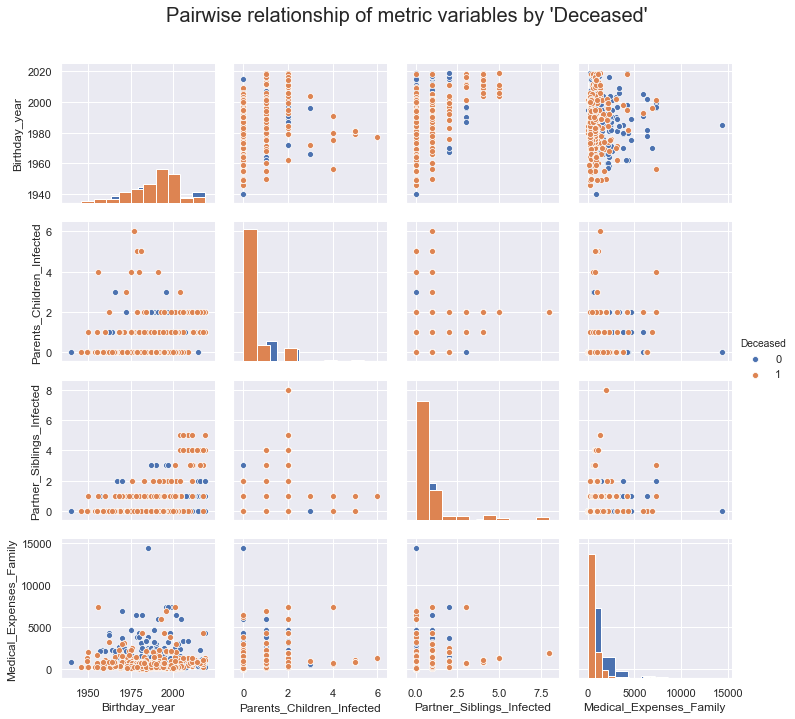

In [46]:
# data to plot
plot_df = pd.concat([X_train[metric_features], y_train], axis=1)

sns.set()

# Setting pairgrid
g = sns.pairplot(plot_df, hue="Deceased", diag_kind="hist")

# Layout
plt.subplots_adjust(top=0.9)
plt.suptitle("Pairwise relationship of metric variables by 'Deceased'", fontsize=20)

plt.show()

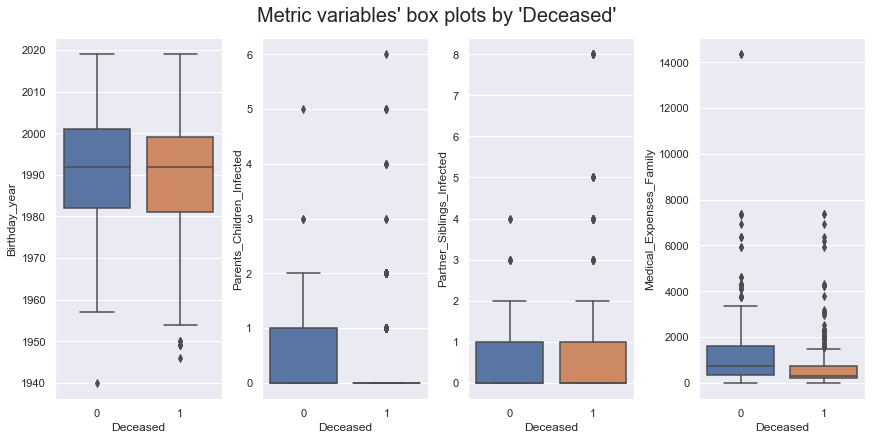

In [48]:
sns.set()

# data to plot
plot_df = pd.concat([X_train[metric_features], y_train], axis=1)
plot_features = metric_features

# Prepare figure
fig, axes = plt.subplots(1, len(plot_features), figsize=(12,6), constrained_layout=True)
    
# Plot data
for ax, f in zip(axes.flatten(), plot_features):
    sns.boxplot(y=f, data=plot_df, ax=ax, x='Deceased')

# Layout
plt.suptitle("Metric variables' box plots by 'Deceased'", fontsize=20)

plt.show()

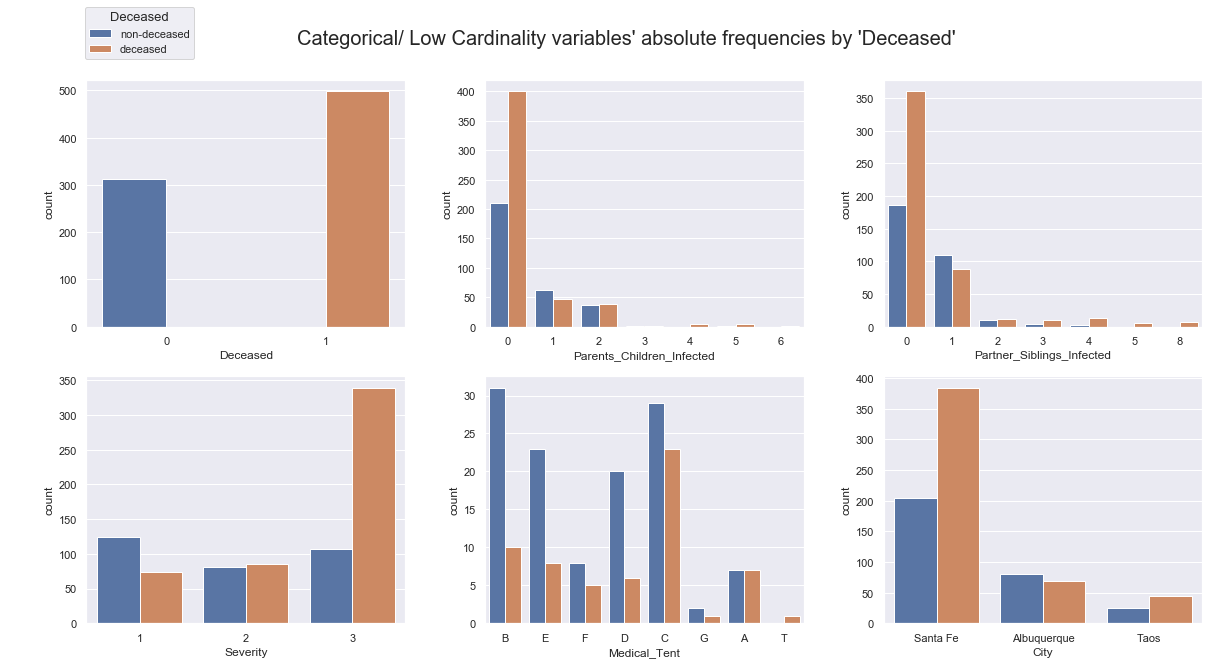

In [49]:
sns.set()

# data to plot
plot_df = pd.concat([X_train[lc_c_features + ["Parents_Children_Infected", "Partner_Siblings_Infected"]], y_train], axis=1)
plot_features = ["Deceased", "Parents_Children_Infected", "Partner_Siblings_Infected"] + lc_c_features

# figure and axes
fig, axes = plt.subplots(2, ceil(len(plot_features)/2), figsize=(20,10))

# plot data
for ax, x in zip(axes.flatten(), plot_features):
    if x == "Deceased":
        sns.countplot(x=x, hue="Deceased", order=[0, 1], data=plot_df, ax=ax)
    else:
        sns.countplot(x=x, hue="Deceased", data=plot_df, ax=ax)
    ax.get_legend().remove()
    
# Set legend (IsCanceled)
handles, _ = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, ["non-deceased", "deceased"], loc=(0.07,0.91), title="Deceased", title_fontsize=13)

plt.subplots_adjust(wspace=0.25)
plt.suptitle("Categorical/ Low Cardinality variables' absolute frequencies by 'Deceased'", y=0.95, fontsize=20)

plt.show()

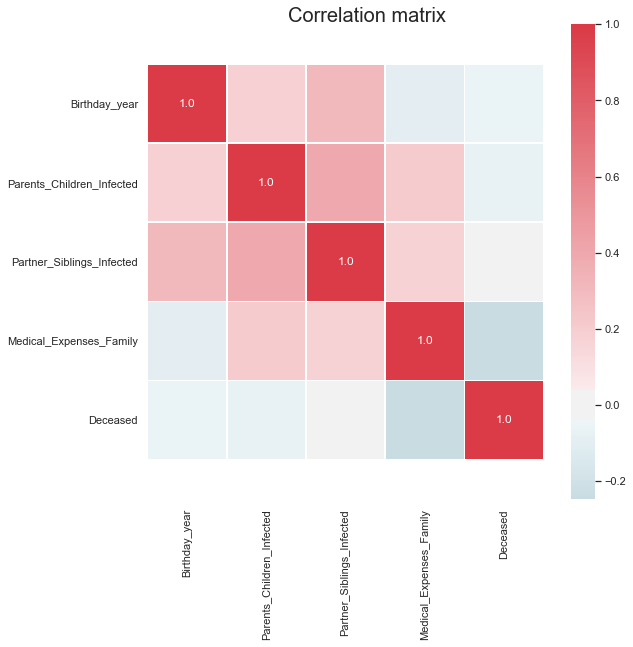

In [51]:
sns.set(style="white")

# Compute the correlation matrix
corr = pd.concat([X_train[metric_features], y_train], axis=1).corr() #Getting correlation of numerical variables

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(10, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True) #Make a diverging palette between two HUSL colors. Return a matplotlib colormap object.

# Pass 2D Numpy array to annot parameter
mask_annot = np.absolute(corr.values)>=0.50 # Annotate correlations above abs(0.5)
annot_arr = np.where(mask_annot, corr.values.round(2), np.full(corr.shape,""))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, center=0, square=True, linewidths=.5, annot=annot_arr, fmt="s", ax=ax)

# Layout
plt.subplots_adjust(top=0.95)
plt.suptitle("Correlation matrix", fontsize=20)
plt.yticks(rotation=0)
# Fixing the bug of partially cut-off bottom and top cells
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

plt.show()

# Data Cleaning

# Modelling